In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *

# Подход 1: градиентный бустинг "в лоб"

Считайте таблицу с признаками из файла features.csv. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [2]:
data_train = pd.read_csv('data/features.csv', index_col='match_id')
X_train = data_train.ix[:,:-6]
X_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [3]:
data_test = pd.read_csv('data/features_test.csv', index_col='match_id')
X_test = data_test
X_test.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

###### Какие признаки имеют пропуски среди своих значений? 

In [4]:
nan_pred = X_train.count() < X_train.shape[0]
nan_cols = [[c, int(float(X_train[c].count())/X_train.shape[0]*100)] for c in X_train.columns[nan_pred].get_values()]
print 'Заполненность признаков:'
for col in sorted(nan_cols, key=lambda x: x[1]): 
    print '{}{}%'.format(col[0].ljust(30), col[1])

Заполненность признаков:
first_blood_player2           54%
radiant_flying_courier_time   71%
dire_flying_courier_time      73%
first_blood_time              79%
first_blood_team              79%
first_blood_player1           79%
radiant_bottle_time           83%
dire_bottle_time              83%
radiant_first_ward_time       98%
dire_first_ward_time          98%
radiant_courier_time          99%
dire_courier_time             99%


###### Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

first_blood_time
first_blood_team
first_blood_player1
first_blood_player2
> Пропуски в этих признаках означают, что за 5 первых минут никто не пролил кровь. Как правило, в начале игры никто не нападает, а зарабатывает и улучшает свои силы.

radiant_bottle_time
radiant_courier_time
radiant_flying_courier_time
dire_bottle_time
dire_courier_time
dire_flying_courier_time
> Пропуски в этих признаках означают, что за 5 первых минут Radiants/Dire не купили соот-щие предметы. В начале игры мало денег, чтобы купить что-то.

radiant_first_ward_time
dire_first_ward_time
> Пропуски в этих признаках означают, что за 5 первых минут Radiants/Dire не установили первого наблюдателя

Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [5]:
X_train.fillna(-10*6, inplace=True)

###### Как называется столбец, содержащий целевую переменную?

In [6]:
y_train = data_train.radiant_win

> Столбец, содержащий целевую переменную: radiant_win. Он определяет победила ли команда Radiant в игре.

Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [7]:
def timeit(func):
    @wraps(func)
    def run_func(*args, **kwargs):
        time_from = datetime.datetime.now()
        result = func(*args, **kwargs)
        time_to = datetime.datetime.now()
        return result, time_to - time_from
    return run_func

In [8]:
kf = KFold(n_splits=5, shuffle=True)

In [9]:
@timeit
def get_gb_score(X, y, num_trees, cv):
    classifier = GradientBoostingClassifier(n_estimators=num_trees, max_depth=5, 
                                            random_state=241)
    score = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='roc_auc')
    return np.mean(score)

measures = pd.DataFrame(columns=['num_trees', 'score', 'time'])

for num_trees in range(10, 70, 10):
    print 'num_trees:', num_trees,
    
    score, t = get_gb_score(X_train, y_train, num_trees, kf)
    
    measures = measures.append({'num_trees' : num_trees, 'score' : score, 'time' : t.seconds}, 
                               ignore_index=True)
    
    print 'score:', score, 'time:', t.seconds

measures

num_trees: 10 score: 0.679564146358 time: 56
num_trees: 20 score: 0.692411299728 time: 108
num_trees: 30 score: 0.698761426399 time: 161
num_trees: 40 score: 0.702600470074 time: 215
num_trees: 50 score: 0.703780956364 time: 266
num_trees: 60 score: 0.707162646395 time: 319


,num_trees,score,time
0,10.0,0.679564,56.0
1,20.0,0.692411,108.0
2,30.0,0.698761,161.0
3,40.0,0.702600,215.0
4,50.0,0.703781,266.0
5,60.0,0.707163,319.0


###### Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

> num_trees: 30 score: 0.698761426399 time: 161s

###### Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

> Начиная с num_trees: 30 качество растет уже не так быстро, а времени на настройку модели уходит много. Можно остановиться на 30 деревьях. Чтобы ускорить настройку при увеличении числа деревьев можно уменьшить максимальную глубину деревьев или попробовать выделить наиболее важные признаки.

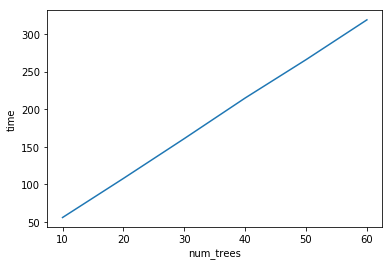

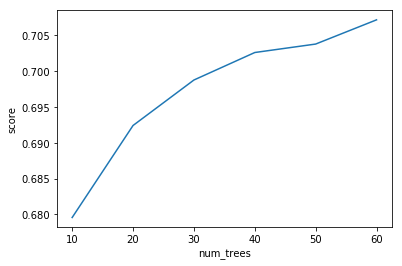

In [20]:
plt.plot(measures.num_trees, measures.time)
plt.xlabel('num_trees')
plt.ylabel('time')
plt.show()

plt.plot(measures.num_trees, measures.score)
plt.xlabel('num_trees')
plt.ylabel('score')
plt.show()

### Подход 2: логистическая регрессия

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [89]:
data_train = pd.read_csv('data/features.csv', index_col='match_id')
data_test = pd.read_csv('data/features_test.csv', index_col='match_id')

X_train = data_train.ix[:,:-6]
y_train = data_train.radiant_win

X_test = data_test

Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [90]:
kf = KFold(n_splits=5, shuffle=True)

In [92]:
@timeit
def get_lr_score(X, y, C, cv):
    classifier = LogisticRegression(C=C, penalty='l2', random_state=241)
    score = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='roc_auc')
    return np.mean(score)

def get_lr_scores(X, y, cv):
    X.fillna(0, inplace=True)
    X = StandardScaler().fit_transform(X)

    measures = pd.DataFrame(columns=['C', 'score', 'time'])

    for C in np.power(10.0, np.arange(-5, 5)):
        print 'C:', C,

        score, t = get_lr_score(X, y, C, cv)

        measures = measures.append({'C' : C, 'score' : score, 'time' : t.seconds}, 
                                   ignore_index=True)

        print 'score:', score, 'time:', t.seconds
        
    return measures

In [93]:
measures_lr = get_lr_scores(X_train, y_train, kf)
measures_lr

C: 1e-05 score: 0.695121888466 time: 3
C: 0.0001 score: 0.711314956562 time: 5
C: 0.001 score: 0.716321452931 time: 7
C: 0.01 score: 0.716474492783 time: 10
C: 0.1 score: 0.716445027241 time: 11
C: 1.0 score: 0.716486017905 time: 11
C: 10.0 score: 0.716484255693 time: 13
C: 100.0 score: 0.71636979309 time: 11
C: 1000.0 score: 0.716365686948 time: 11
C: 10000.0 score: 0.716513023739 time: 11


,C,score,time
0,0.00001,0.695122,3.0
1,0.00010,0.711315,5.0
2,0.00100,0.716321,7.0
3,0.01000,0.716474,10.0
4,0.10000,0.716445,11.0
5,1.00000,0.716486,11.0
6,10.00000,0.716484,13.0
7,100.00000,0.716370,11.0
8,1000.00000,0.716366,11.0
9,10000.00000,0.716513,11.0


In [94]:
best_lr_idx = np.argmax(measures_lr.score)
measures_lr.ix[best_lr_idx,:]

C        10000.000000
score        0.716513
time        11.000000
Name: 9, dtype: float64

###### Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

> LR: C: 10000.0 score: 0.716513023739 time: 11s

> GB: num_trees: 30 score: 0.698761426399 time: 161s

> Логистическая регрессия дает более точную оценку, чем градиентный бустинг, и обучается намного быстрее.

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [95]:
print X_train.shape

drop_columns = ['lobby_type']
for i in range(1,6):
    drop_columns.append('r{}_hero'.format(i))
    drop_columns.append('d{}_hero'.format(i))
X_train_wo_cat = X_train.drop(drop_columns, axis=1)

print X_train_wo_cat.shape

(97230, 102)
(97230, 91)


In [96]:
measures_lr_wo_cat = get_lr_scores(X_train_wo_cat, y_train, kf)
measures_lr_wo_cat

C: 1e-05 score: 0.695104983245 time: 2
C: 0.0001 score: 0.711219059718 time: 3
C: 0.001 score: 0.716455981271 time: 6
C: 0.01 score: 0.71642773946 time: 9
C: 0.1 score: 0.716608838848 time: 10
C: 1.0 score: 0.716481526611 time: 9
C: 10.0 score: 0.716267744887 time: 9
C: 100.0 score: 0.716421258958 time: 9
C: 1000.0 score: 0.716201405243 time: 10
C: 10000.0 score: 0.716279468082 time: 9


,C,score,time
0,0.00001,0.695105,2.0
1,0.00010,0.711219,3.0
2,0.00100,0.716456,6.0
3,0.01000,0.716428,9.0
4,0.10000,0.716609,10.0
5,1.00000,0.716482,9.0
6,10.00000,0.716268,9.0
7,100.00000,0.716421,9.0
8,1000.00000,0.716201,10.0
9,10000.00000,0.716279,9.0


In [97]:
best_lr_wo_cat_idx = np.argmax(measures_lr_wo_cat.score)
measures_lr_wo_cat.ix[best_lr_wo_cat_idx,:]

C         0.100000
score     0.716609
time     10.000000
Name: 4, dtype: float64

###### Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

> С категориальными признаками: C: 10000.0 score: 0.716513023739 time: 11s

> Без категориальных признаков: C: 0.1 score: 0.716608838848 time: 10s

> Логистическая регрессия плохо учитывает категориальные признаки, поэтому при удалении их из выборки точность оценки немного улучшается. Улучшение не большое, так как метод достаточно устойчив в шумам.

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

###### Сколько различных идентификаторов героев существует в данной игре?

In [98]:
for c in drop_columns:
    print 'column:', c, 'max_value:',
    print np.max(np.unique(data_train[c]))

column: lobby_type max_value: 7
column: r1_hero max_value: 112
column: d1_hero max_value: 112
column: r2_hero max_value: 112
column: d2_hero max_value: 112
column: r3_hero max_value: 112
column: d3_hero max_value: 112
column: r4_hero max_value: 112
column: d4_hero max_value: 112
column: r5_hero max_value: 112
column: d5_hero max_value: 112


> В игре может принимать участие 112 различных героев

Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [111]:
def get_bag_of_words(data):
    heros = 112
    X_pick = np.zeros((data.shape[0], heros))

    for i, match_id in enumerate(data.index):
        for p in xrange(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

    X_pick = pd.DataFrame(X_pick, columns=[str(i) for i in range(1, heros+1)])
    
    return X_pick

def add_back_of_words(data, X):
    X_pick = get_bag_of_words(data)
    X_res = pd.DataFrame(np.hstack((X, X_pick)), 
                         columns=np.hstack((X.columns, X_pick.columns)))
    return X_res

In [112]:
X_train_bag_of_words = add_back_of_words(X_train, X_train_wo_cat)
print X_train_bag_of_words.shape

(97230, 203)


Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [101]:
measures_lr_bag_of_words = get_lr_scores(X_train_bag_of_words, y_train, kf)
measures_lr_bag_of_words

C: 1e-05 score: 0.71492539347 time: 4
C: 0.0001 score: 0.742838667346 time: 7
C: 0.001 score: 0.751686395585 time: 14
C: 0.01 score: 0.75172371436 time: 22
C: 0.1 score: 0.751779981241 time: 21
C: 1.0 score: 0.751906431367 time: 23
C: 10.0 score: 0.752093605294 time: 25
C: 100.0 score: 0.751904387955 time: 22
C: 1000.0 score: 0.751701003334 time: 21
C: 10000.0 score: 0.751631860692 time: 21


,C,score,time
0,0.00001,0.714925,4.0
1,0.00010,0.742839,7.0
2,0.00100,0.751686,14.0
3,0.01000,0.751724,22.0
4,0.10000,0.751780,21.0
5,1.00000,0.751906,23.0
6,10.00000,0.752094,25.0
7,100.00000,0.751904,22.0
8,1000.00000,0.751701,21.0
9,10000.00000,0.751632,21.0


In [102]:
best_lr_bag_of_words = np.argmax(measures_lr_bag_of_words.score)
measures_lr_bag_of_words.ix[best_lr_bag_of_words,:]

C        10.000000
score     0.752094
time     25.000000
Name: 6, dtype: float64

###### Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

> Без категориальных признаков: C: 0.1 score: 0.716608838848 time: 10s

> С мешком слов по героям: C: 10.0 score: 0.752093605294 time: 25s

> С мешком слов метод дает намного лучше оценку (на 5% лучше), так как важные категориальные признаки сейчас учитываются правильно.

Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [148]:
scaler = StandardScaler()

X_train_bag_of_words_ready = X_train_bag_of_words.fillna(0)
X_train_bag_of_words_ready = pd.DataFrame(scaler.fit_transform(X_train_bag_of_words_ready),
                                          columns=X_train_bag_of_words_ready.columns)

X_test_wo_cat = X_test.drop(drop_columns, axis=1)
X_test_bag_of_words = add_back_of_words(X_test, X_test_wo_cat)

X_test_bag_of_words_ready = X_test_bag_of_words.fillna(0)
X_test_bag_of_words_ready = pd.DataFrame(scaler.transform(X_test_bag_of_words_ready),
                                         columns=X_test_bag_of_words_ready.columns)

print X_test_bag_of_words_ready.shape

(17177, 203)


In [149]:
winner = LogisticRegression(C=10, penalty='l2')
winner = winner.fit(X_train_bag_of_words_ready, y_train)

In [151]:
pred = winner.predict_proba(X_test_bag_of_words_ready)[:,1]
pred

array([ 0.8250884 ,  0.75456503,  0.18722805, ...,  0.23522048,
        0.62921766,  0.42441314])

###### Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [152]:
min_pred = np.min(pred)
max_pred = np.max(pred)
print 'Max prediction:', max_pred
print 'Min prediction:', min_pred

Max prediction: 0.996438938549
Min prediction: 0.00845618875521


> Max prediction: 0.996438938549

> Min prediction: 0.00845618875521